In [1]:
using POMDPs
using QuickPOMDPs
using POMDPModelTools
using POMDPSimulators
using POMDPPolicies
using Random
using Plots
using LinearAlgebra
using IJulia

┌ Info: Precompiling QuickPOMDPs [8af83fb2-a731-493c-9049-9e19dbce6165]
└ @ Base loading.jl:1273


# Discrete Explicit Example

1x10 Grid world with +10 reward at cell 8.
Actions are to try to go left or right.
Discount is 0.95

In [2]:
S = 1:10 # same as [1,2,3,4,5,6,7, 8, 9, 10]
A = [-1, 1]

function T(s, a, sp)
    if sp == clamp(s + a, 1, 10)
        return 0.75
    elseif sp == clamp(s - a, 1, 10)
        return 0.25
    else
        return 0.0
    end
end

function R(s, a)
    if s == 8
        return 10.0
    else
        return 0.0
    end
end

γ = 0.95

0.95

In [3]:
gw = DiscreteExplicitMDP(S,A,T,R,γ);

┌ Warning: trans_prob_consistency_check(m) is deprecated. Use @test has_consistent_transition_distributions(m) instead.
└ @ POMDPTesting /home/zach/.julia/dev/POMDPTesting/src/model.jl:171


In [4]:
function POMDPModelTools.render(m::typeof(gw), step)
    str = "|"
    for s in states(m)
        if s == step.s
            str *= "s|"
        else
            str *= " |"
        end
    end
    return str
end

In [5]:
policy = FunctionPolicy(s->1);

In [6]:
ds = DisplaySimulator(max_steps=20, max_fps=100)
simulate(ds, gw, policy)

"| | | | | | |s| | | |"

"| | | | | | | |s| | |"

"| | | | | | | | |s| |"

"| | | | | | | |s| | |"

"| | | | | | |s| | | |"

"| | | | | | | |s| | |"

"| | | | | | | | |s| |"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | |s| |"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | | |s|"

"| | | | | | | | |s| |"

25.811559374999995

In [7]:
function mc_evaluate(policy; n_simulations=1000)
    rs = RolloutSimulator(max_steps=100)
    rsum = 0.0
    for i in 1:n_simulations
        rsum += simulate(rs, gw, policy)
    end
    return rsum/n_simulations
end

mc_evaluate (generic function with 1 method)

In [8]:
mc_evaluate(policy)

18.864579073284492

In [10]:
better_policy = FunctionPolicy(
    function (s)
        if s <= 8
            return 1
        else
            return -1
        end
    end
)

mc_evaluate(better_policy)

57.224246995979996

# Distributions in Julia

Often, you'll need an object that represents a distribution. Pre-made objects for this can be found in Distributions.jl and POMDPModelTools.jl

The interface for a distribution includes
```julia
rand(rng, d) # samples a value from the distribution. rng is a random number generator, e.g. Random.GLOBAL_RNG
pdf(d, s) # returns the probability (or density) of value f in the distribution
support(d)
mode(d)
mean(d)
```

In [11]:
using Distributions

mvn = MvNormal(zeros(2), I)

IsoNormal(
dim: 2
μ: [0.0, 0.0]
Σ: [1.0 0.0; 0.0 1.0]
)


In [12]:
rng = Random.GLOBAL_RNG

rand(rng, mvn)

2-element Array{Float64,1}:
 0.13898364210333827
 0.30208941231327957

In [14]:
c = Categorical(3)

@show rand(rng, c)
@show pdf(c, 4)
@show pdf(c, 2)

rand(rng, c) = 3
pdf(c, 4) = 0.0
pdf(c, 2) = 0.3333333333333333


0.3333333333333333

In [18]:
d = SparseCat(["first", "second", "third"], [0.2, 0.5, 0.3])

@show rand(rng, d)
@show pdf(d, "second")

rand(rng, d) = "second"
pdf(d, "second") = 0.5


0.5

In [20]:
support(Normal(0.0))

RealInterval(-Inf, Inf)

# Problem with Continuous States (Generative Definition)

Satellite

In [25]:
function sdot(s)
    x, y, xdot, ydot = s
    rsquared = x^2 + y^2
    xddot = -x/(rsquared*sqrt(rsquared))
    yddot = -y/(rsquared*sqrt(rsquared))
    return [xdot, ydot, xddot, yddot]
end

function space_reward(s, a, sp)
    x, y, xdot, ydot = s
    r = sqrt(x^2+y^2)
    return -(r-5) - norm(a)
end

space_reward (generic function with 1 method)

In [32]:
satellite = QuickMDP(
    function (s, a, rng)
        sp = s + 0.1*(sdot(s) + [0, 0, a[1], a[2]]) + 0.00001*randn(rng, 4)
        r = space_reward(s, a, sp)
        return (sp=sp, r=r)
    end,
    initialstate = [0.0, 4.0, 1.0, 0.0],
    actiontype = Vector{Float64}
)

QuickMDP{UUID("93986b16-c2ea-402b-981d-e895830e39a2"),Array{Float64,1},Array{Float64,1},NamedTuple{(:isterminal, :initialstate, :gen, :discount, :actiontype),Tuple{Bool,Array{Float64,1},var"#28#29",Float64,DataType}}}((isterminal = false, initialstate = [0.0, 4.0, 1.0, 0.0], gen = var"#28#29"(), discount = 1.0, actiontype = Array{Float64,1}))

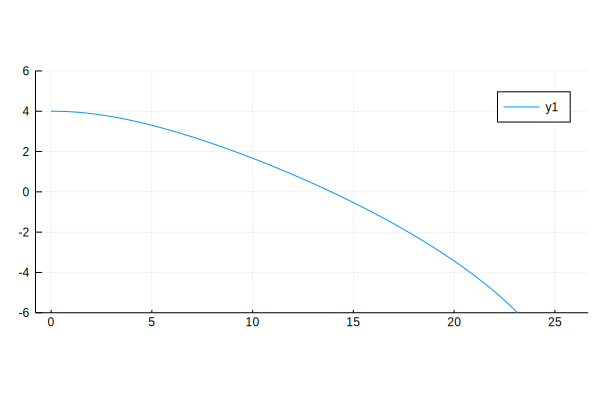

rsum = -17152.707690578118


-17152.707690578118

In [33]:
xs = Float64[]
ys = Float64[]
policy = FunctionPolicy(s->[-0.01,0.0])
rsum = 0.0
for (s,r) in stepthrough(satellite, policy, "s,r", max_steps=1000)
    push!(xs, s[1])
    push!(ys, s[2])
    IJulia.clear_output(true)
    display(plot(xs, ys, ylim=(-6,6), aspect_ratio=1))
    rsum += r
end
@show rsum

# Continuous State/Action MDP with EXPLICIT DEFINITION

In [34]:
explicit_satellite = QuickMDP(
    transition = function (s, a)
        next_mean = s + 0.1*(sdot(s) + [0, 0, a...])
        return MvNormal(next_mean, 0.001*I)
    end,
    reward = space_reward,
    initialstate = [0.0, 4.0, 1.0, 0.0],
    actiontype = Vector{Float64}
)

QuickMDP{UUID("ff4e76f1-9605-4b40-8965-21546962eba5"),Array{Float64,1},Array{Float64,1},NamedTuple{(:isterminal, :transition, :reward, :initialstate, :discount, :actiontype),Tuple{Bool,var"#32#33",typeof(space_reward),Array{Float64,1},Float64,DataType}}}((isterminal = false, transition = var"#32#33"(), reward = space_reward, initialstate = [0.0, 4.0, 1.0, 0.0], discount = 1.0, actiontype = Array{Float64,1}))

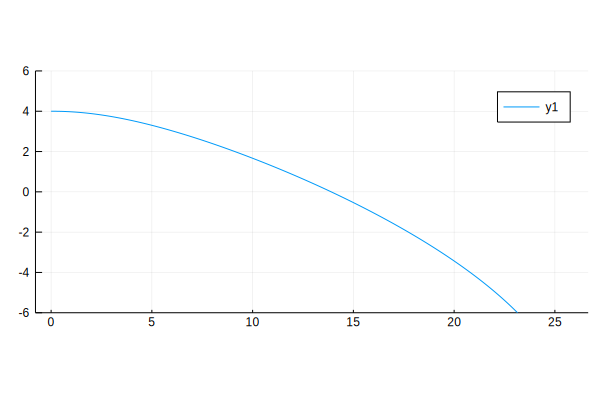

rsum = -17151.700898563315


-17151.700898563315

In [35]:
xs = Float64[]
ys = Float64[]
policy = FunctionPolicy(s->[-0.01,0.0])
rsum = 0.0
for (s,r) in stepthrough(satellite, policy, "s,r", max_steps=1000)
    push!(xs, s[1])
    push!(ys, s[2])
    IJulia.clear_output(true)
    display(plot(xs, ys, ylim=(-6,6), aspect_ratio=1))
    rsum += r
end
@show rsum